In [1]:
import numpy as np
import pandas as pd
import glob

from sklearn.preprocessing import MultiLabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt


## Matplotlib Settings

In [2]:
# references: 
# https://ranocha.de/blog/colors/#gsc.tab=0
# https://medium.com/p/d023f74515b4
# https://towardsdatascience.com/5-powerful-tricks-to-visualize-your-data-with-matplotlib-16bc33747e05
import os
from matplotlib.ticker import MultipleLocator
from cycler import cycler

style = 'default'

plt.style.use(style)

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"

plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0

plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0

plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10

plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 14
plt.rcParams['axes.linewidth'] = 3.0

plt.rcParams['legend.handlelength'] = 5.0

plt.rc("lines", linewidth=2.5, markersize=10, markeredgewidth=2.5)
plt.rc("legend", loc="best", fontsize=8, fancybox=True, framealpha=0.5)
plt.rc("savefig", dpi=600)

line_cycler   = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["-", "--", "-.", ":", "-", "--", "-."]))
plt.rc("axes", prop_cycle=line_cycler)

directory = "./figs/"

## Analysis

### Records per file

In [3]:
files = sorted(glob.glob("../storage/datasets/csv/*.csv"))
print(files)
datasets = []
for file in files:
    datasets.append(pd.read_csv(file, sep="\t"))
    
for i, dataset in enumerate(datasets):
    mlb = MultiLabelBinarizer()
    targets = mlb.fit_transform(dataset["Sustainable Development Goals (2021)"].\
                                str.replace(" ", "").\
                                str.split("|"))
    targets_dataframe = pd.DataFrame(targets, columns=mlb.classes_, dtype=np.float32)

    datasets[i] = pd.concat([datasets[i], targets_dataframe], axis=1)
    datasets[i] = datasets[i].drop(columns=["Sustainable Development Goals (2021)"])

['../storage/datasets/csv/SDG_01.csv', '../storage/datasets/csv/SDG_02.csv', '../storage/datasets/csv/SDG_03.csv', '../storage/datasets/csv/SDG_04.csv', '../storage/datasets/csv/SDG_05.csv', '../storage/datasets/csv/SDG_06.csv', '../storage/datasets/csv/SDG_07.csv', '../storage/datasets/csv/SDG_08.csv', '../storage/datasets/csv/SDG_09.csv', '../storage/datasets/csv/SDG_10.csv', '../storage/datasets/csv/SDG_11.csv', '../storage/datasets/csv/SDG_12.csv', '../storage/datasets/csv/SDG_13.csv', '../storage/datasets/csv/SDG_14.csv', '../storage/datasets/csv/SDG_15.csv', '../storage/datasets/csv/SDG_16.csv']


In [4]:
sdg_counts = []

samples = 0
for file, dataset in zip(files, datasets):
    sdg_name = file.split('/')[-1].split(".")[0].replace("_", " ")
    sdg_count = dataset.shape[0]
     
    sdg_counts.append((sdg_name, sdg_count))
    
    samples += sdg_count 
    print(f"{sdg_name}: {samples}")
    
sdg_counts = pd.DataFrame(sdg_counts, columns=["SDG", "Count"])

SDG 01: 34982
SDG 02: 134554
SDG 03: 199191
SDG 04: 303259
SDG 05: 371169
SDG 06: 504814
SDG 07: 719343
SDG 08: 837181
SDG 09: 1038786
SDG 10: 1176337
SDG 11: 1351187
SDG 12: 1461465
SDG 13: 1586108
SDG 14: 1668427
SDG 15: 1759459
SDG 16: 1856722


/tmp/ipykernel_7188/3598003834.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


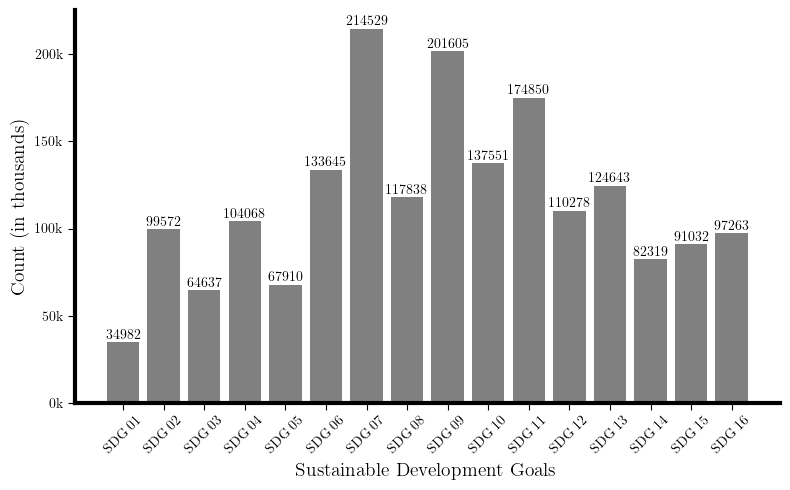

In [5]:
fig, ax = plt.subplots()

# Create the bar plot
ax.bar(sdg_counts['SDG'], 
       sdg_counts['Count'], 
       color="gray")

# Add labels and a title
ax.set_xlabel('Sustainable Development Goals')
ax.set_ylabel('Count (in thousands)')
# ax.set_title('Number of Records Extracted from SciVal for each SDG')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45, ha="center")
ylabels = [str(int(y)) + 'k' for y in ax.get_yticks() / 1000]
ax.set_yticklabels(ylabels)

bars = plt.bar(sdg_counts['SDG'], sdg_counts['Count'], color="gray")

# Annotate each bar with its corresponding count value
for bar in bars:
    yval = bar.get_height()
    plt.text(x=bar.get_x() + bar.get_width() / 2, 
             y=yval + 2000, 
             s=yval, 
             ha='center', 
             fontsize=10, 
             fontfamily="serif"
             )

# Remove top and right spines for a cleaner look
sns.despine()

figname = "counts.png"
# Show the plot
plt.tight_layout()
plt.savefig(os.path.join(directory, figname), bbox_inches="tight")
plt.show()

### Distribution of labels Before and After Removing Duplicates

In [5]:
def remove_duplicates(dataset):
    # remove duplicate data
    dataset = dataset.drop_duplicates()

    # perform union set on labels for duplicated text entries but different target
    # sets
    text_data = dataset[["text"]].copy()
    SDG_columns = [col for col in dataset.columns if col.startswith('SDG')]

    title_counts = text_data["text"].value_counts()
    duplicated_titles = title_counts[title_counts > 1].index.tolist()

    aggregated_rows = []
    for title in duplicated_titles:
        title_data = dataset[SDG_columns].loc[dataset["text"] == title, :]
        sdgs = title_data.sum(axis=0) > 0
        sdgs = sdgs.astype(int).tolist()

        agg_data = [title]
        agg_data.extend(sdgs)

        aggregated_rows.append(agg_data)
    deduplicated_records = pd.DataFrame(aggregated_rows, columns=["text"] + SDG_columns)

    deduplicated_dataset = dataset.loc[~dataset["text"].isin(duplicated_titles)]
    deduplicated_dataset = pd.concat([deduplicated_dataset, deduplicated_records],
                                     ignore_index=True)
    
    return deduplicated_dataset

In [6]:
samples = []
for dataset in datasets:
    samples.append(dataset)
    
data = pd.concat(samples)
data = data.rename(columns={"Title": "text"})
data = data.reset_index(drop=True)

In [7]:
data_dedup = remove_duplicates(data)

In [8]:
label_counts = (
    data
    .iloc[:, 1:]
    .sum(axis=0)
    .to_frame()
    .reset_index()
    .rename(columns={"index": "SDG", 0: "Count"})
)
label_counts["SDG"] = label_counts["SDG"].apply(lambda x: 'SDG ' + str(int(x[3:])).zfill(2))
label_counts["Count"] = label_counts["Count"].astype(np.int64)
label_counts = label_counts.sort_values(by="SDG", ascending=True)

In [9]:
label_counts_dedup = (
    data_dedup
    .iloc[:, 1:]
    .sum(axis=0)
    .to_frame()
    .reset_index()
    .rename(columns={"index": "SDG", 0: "Count"})
)
label_counts_dedup["SDG"] = label_counts_dedup["SDG"].apply(lambda x: 'SDG ' + str(int(x[3:])).zfill(2))
label_counts_dedup["Count"] = label_counts_dedup["Count"].astype(np.int64)
label_counts_dedup = label_counts_dedup.sort_values(by="SDG", ascending=True)


In [10]:
label_counts

,SDG,Count
0,SDG 01,83470
8,SDG 02,181140
9,SDG 03,249191
10,SDG 04,151681
11,SDG 05,120897
12,SDG 06,238204
13,SDG 07,343391
14,SDG 08,278841
15,SDG 09,351881
1,SDG 10,222361


In [11]:
label_counts_dedup

,SDG,Count
0,SDG 01,34956
8,SDG 02,99494
9,SDG 03,193310
10,SDG 04,103915
11,SDG 05,67824
12,SDG 06,133547
13,SDG 07,243047
14,SDG 08,117994
15,SDG 09,201098
1,SDG 10,137364


/tmp/ipykernel_7386/344641635.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


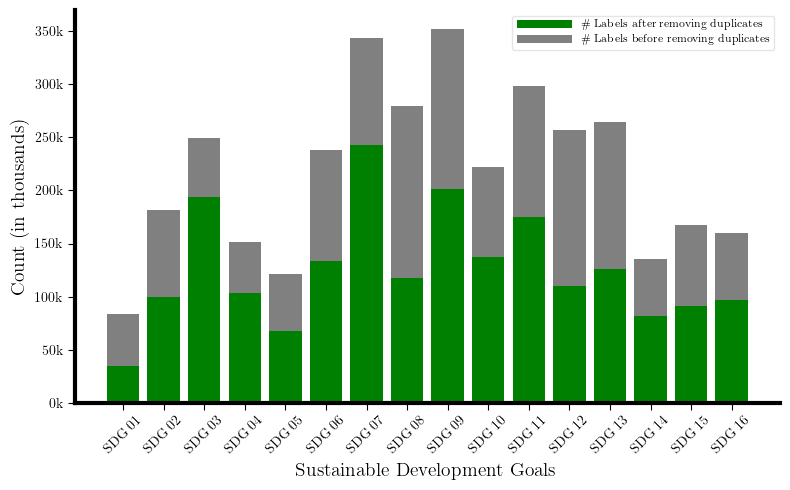

In [15]:
fig, ax = plt.subplots()

# Create the bar plot
ax.bar(label_counts_dedup['SDG'], 
       label_counts_dedup['Count'], 
       color="green",
       label="\# Labels after removing duplicates")

ax.bar(label_counts['SDG'], 
       label_counts["Count"] - label_counts_dedup['Count'], 
       bottom=label_counts_dedup["Count"],
       color="gray",
       label="\# Labels before removing duplicates")

# Add labels and a title
ax.set_xlabel('Sustainable Development Goals')
ax.set_ylabel('Count (in thousands)')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45, ha="center")
ylabels = [str(int(y)) + 'k' for y in ax.get_yticks() / 1000]
ax.set_yticklabels(ylabels)

# bars = plt.bar(sdg_counts['SDG'], sdg_counts['Count'], color="gray")

# Annotate each bar with its corresponding count value
# for bar in bars:
#     yval = bar.get_height()
#     plt.text(x=bar.get_x() + bar.get_width() / 2, 
#              y=yval + 2000, 
#              s=yval, 
#              ha='center', 
#              fontsize=10, 
#              fontfamily="serif"
#              )

# Remove top and right spines for a cleaner look
sns.despine()

figname = "label_counts.png"
plt.legend()
# Show the plot
plt.tight_layout()
plt.savefig(os.path.join(directory, figname), bbox_inches="tight")
plt.show()

### Dataset Balancing

In [12]:
def balance_multilabel_dataset(dataset, quantile=0.5, random_state=42):
    """
    Balance the counts of target labels in a multilabel dataset.

    The function balances the counts of target labels in a dataset by iteratively sampling instances from
    classes with more instances until all classes have the same count of instances. The sample is chosen so
    that it maintains the ratio of labels within the target columns.

    Parameters:
    dataset (dataframe): The unbalanced dataset
    quantile (float, optional): the quantile of the counts of labels at which to balance the dataset.
    If you choose 1, the dataset will remain the same. If you choose 0, then the dataset will be almost
    as balanced as possible. however, you'll probably lose many data. Default value is 0.5 (median).
    random_state (int, optional): the random seed used to sample the dataframe. Default is 42.

    Returns:
    dataset (dataframe): a balanced dataset.
    Example:
    >>> unbalanced_dataset = pd.read_csv("unbalanced_dataset.csv")
    >>> balanced_dataset = balance_multilabel_dataset(unbalanced_dataset)
    """
    # compute the overall counts of labels in the dataset before multilabel balancing
    sdg_counts = dataset.iloc[:, 1:].sum(axis=0)

    # compute the quantile label count and identify those labels below it
    quantile_label_count = np.quantile(sdg_counts, q=quantile)

    # compute the number of samples to add from each label to reach the quantile of the
    # number of samples
    samples_to_add = quantile_label_count - sdg_counts
    samples_to_add[samples_to_add < 0] = quantile_label_count

    # sort label from the minimum to maximum label count
    sorted_labels = dataset.iloc[:, 1:].sum(axis=0).sort_values().index.tolist()

    balanced_dataset = pd.DataFrame(columns=dataset.columns)

    for label in sorted_labels:
        # compute the number of records that must be sampled for current label
        label_samples_to_add = int(samples_to_add[label])
        samples_available = np.sum(dataset[label] == 1)

        label_has_samples_available = samples_available > 0
        label_needs_more_samples = label_samples_to_add > 0

        if label_has_samples_available and label_needs_more_samples:
            # creates a mask to filter the dataset with the samples from current label
            samples_from_selected_label = dataset[label] == 1

            # guarantee that it will not try to add more samples than there is available
            if label_samples_to_add > samples_available:
                label_samples_to_add = samples_available

            # samples the dataset
            selected_samples = dataset[samples_from_selected_label].sample(
                n=label_samples_to_add, random_state=random_state
            )

            # remove the selected samples from the dataset in order
            # to avoid those samples in the next iteration
            dataset = dataset[~samples_from_selected_label]

            # concatenate the balanced_dataset with the selected_samples
            balanced_dataset = pd.concat([balanced_dataset, selected_samples])

        # update the counts of samples to be added to the next labels
        balanced_label_count = balanced_dataset.iloc[:, 1:].sum(axis=0)
        samples_to_add = quantile_label_count - balanced_label_count

    return balanced_dataset

In [15]:
label_counts_dedup["Count"].median()

114069.0

In [13]:
balance_quantile = 0.5
random_state = 42

balanced_dataset = balance_multilabel_dataset(
        data_dedup, quantile=balance_quantile, random_state=random_state
    )

In [14]:
label_counts_balanced = (
    balanced_dataset
    .iloc[:, 1:]
    .sum(axis=0)
    .to_frame()
    .reset_index()
    .rename(columns={"index": "SDG", 0: "Count"})
)
label_counts_balanced["SDG"] = label_counts_balanced["SDG"].apply(lambda x: 'SDG ' + str(int(x[3:])).zfill(2))
label_counts_balanced["Count"] = label_counts_balanced["Count"].astype(np.int64)
label_counts_balanced = label_counts_balanced.sort_values(by="SDG", ascending=True)


/tmp/ipykernel_3471/355782666.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


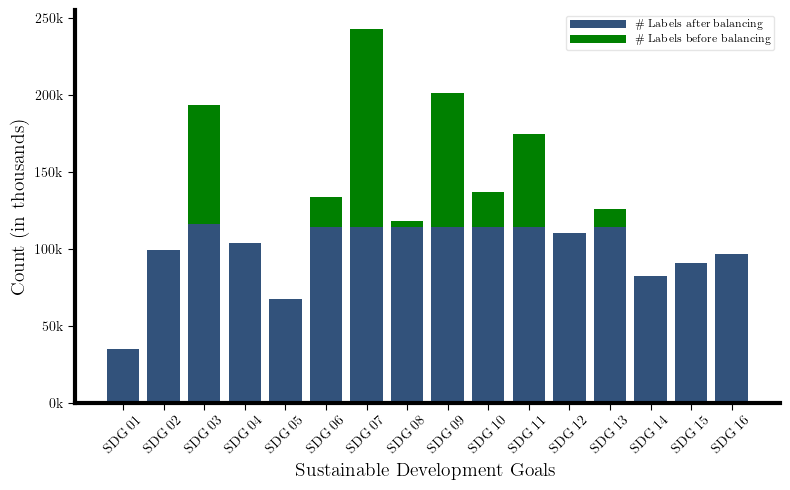

In [16]:
fig, ax = plt.subplots()

# Create the bar plot
ax.bar(label_counts_balanced['SDG'], 
       label_counts_balanced['Count'], 
       color="#32527b",
       label="\# Labels after balancing")

ax.bar(label_counts_dedup['SDG'], 
       label_counts_dedup["Count"] - label_counts_balanced['Count'], 
       bottom=label_counts_balanced["Count"],
       color="green",
       label="\# Labels before balancing")

# Add labels and a title
ax.set_xlabel('Sustainable Development Goals')
ax.set_ylabel('Count (in thousands)')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45, ha="center")
ylabels = [str(int(y)) + 'k' for y in ax.get_yticks() / 1000]
ax.set_yticklabels(ylabels)

# bars = plt.bar(sdg_counts['SDG'], sdg_counts['Count'], color="gray")

# Annotate each bar with its corresponding count value
# for bar in bars:
#     yval = bar.get_height()
#     plt.text(x=bar.get_x() + bar.get_width() / 2, 
#              y=yval + 2000, 
#              s=yval, 
#              ha='center', 
#              fontsize=10, 
#              fontfamily="serif"
#              )

# Remove top and right spines for a cleaner look
sns.despine()

figname = "balanced_counts.png"
plt.legend()
# Show the plot
plt.tight_layout()
plt.savefig(os.path.join(directory, figname), bbox_inches="tight")
plt.show()